In [103]:
import ants
import cv2
import cupy as cp
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil


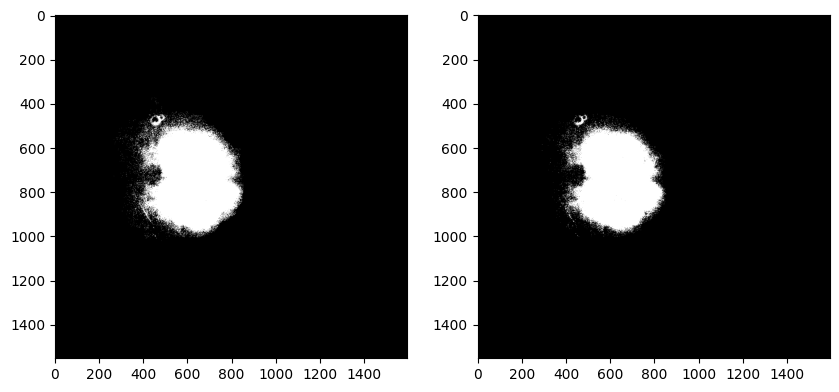

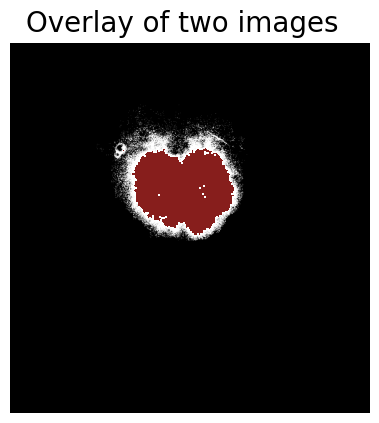

In [42]:
img1 = cv2.imread(f'{retinex_path}/{retinex_slides[0]}', cv2.IMREAD_GRAYSCALE)
img1 = img1/255
# img1 = img1<0.84
# img1 = img1.astype(np.uint8)
img2 = cv2.imread(f'{retinex_path}/{retinex_slides[1]}', cv2.IMREAD_GRAYSCALE)
img2 = img2/255
# img2 = img2<0.83
# img2 = img2.astype(np.uint8)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img1, cmap='gray')
ax[1].imshow(img2, cmap='gray')
img1 = ants.from_numpy(img1)
img2 = ants.from_numpy(img2)
plt.show()
ants.plot(img1, overlay=img2, nslices=1, axis=2, title='Overlay of two images')


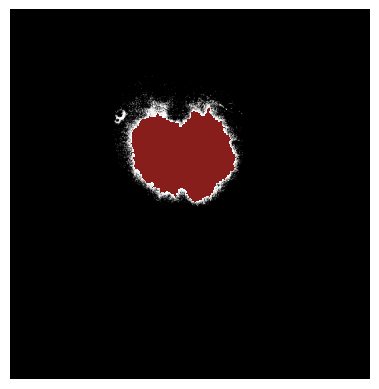

In [53]:
ants.plot(img2, overlay=img1.get_mask(cleanup=4))

In [81]:
ref_slide_idx = retinex_slides[1566]

'1606_retinex.jpg'

In [ ]:
retinex_path = 'rf_trained_pred/retinex'
retinex_slides = os.listdir(retinex_path)
original_path = 'rf_trained_pred/original'
original_slides = os.listdir(original_path)
retinex_slides = sorted(retinex_slides)
retinex_slides[13:-50][-1]
sel = slice(13, -20, None)
retinex_slides = retinex_slides[sel]
original_slides = sorted(original_slides)
original_slides = original_slides[sel]

In [105]:
import ants
import cv2
import cupy as cp
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
from tqdm import trange

retinex_path = 'rf_trained_pred/retinex'
retinex_slides = os.listdir(retinex_path)
original_path = 'rf_trained_pred/original'
original_slides = os.listdir(original_path)
retinex_slides = sorted(retinex_slides)
sel = slice(13, -20, None)
retinex_slides = retinex_slides[sel]
original_slides = sorted(original_slides)
original_slides = original_slides[sel]


def register_fwd(fixed_idx, moving_idx, retinex_path=retinex_path, retinex_slides=retinex_slides, original_path=original_path, original_slides=original_slides):
    img1_bgr = cv2.imread(f'{retinex_path}/{retinex_slides[fixed_idx]}')
    img1 = cv2.cvtColor(img1_bgr, cv2.COLOR_BGR2GRAY)
    img1 = img1/255
    img1 = img1<0.84
    img1 = img1.astype(np.uint8)
    img2_bgr = cv2.imread(f'{retinex_path}/{retinex_slides[moving_idx]}')
    img2 = cv2.cvtColor(img2_bgr, cv2.COLOR_BGR2GRAY)
    img2 = img2/255
    img2 = img2<0.83
    img2 = img2.astype(np.uint8)
    img1 = ants.from_numpy(img1)
    img2 = ants.from_numpy(img2)
    # Affine registration
    registration_params = {
        'type_of_transform': 'TRSAA',
        'mask': img1.get_mask(cleanup=4),
        'moving_mask': img2.get_mask(cleanup=4),
        'fixed': img1,
        'moving': img2,
        'aff_sampling': 4,
        'aff_metric': 'GC',
        'flow_sigma': 2,
        
    }
    affine = ants.registration(**registration_params)
    fwdaffine = ants.read_transform(affine['fwdtransforms'][0])
    img2_b = fwdaffine.apply_to_image(ants.from_numpy(img2_bgr[..., 0]))
    img2_g = fwdaffine.apply_to_image(ants.from_numpy(img2_bgr[..., 1]))
    img2_r = fwdaffine.apply_to_image(ants.from_numpy(img2_bgr[..., 2]))
    img2_bgr = cv2.merge([img2_b.numpy(), img2_g.numpy(), img2_r.numpy()])
    img2_orig_bgr = cv2.imread(f'{original_path}/{original_slides[moving_idx]}')
    img2_orig_b = fwdaffine.apply_to_image(ants.from_numpy(img2_orig_bgr[..., 0]))
    img2_orig_g = fwdaffine.apply_to_image(ants.from_numpy(img2_orig_bgr[..., 1]))
    img2_orig_r = fwdaffine.apply_to_image(ants.from_numpy(img2_orig_bgr[..., 2]))
    img2_orig_bgr = cv2.merge([img2_orig_b.numpy(), img2_orig_g.numpy(), img2_orig_r.numpy()])
    cv2.imwrite(f'aff_reg/retinex/aff_{retinex_slides[moving_idx]}', img2_bgr)
    cv2.imwrite(f'aff_reg/original/aff_{original_slides[moving_idx]}', img2_orig_bgr)
    shutil.copy(affine['fwdtransforms'][0], f'aff_reg/transforms/{moving_idx}_{fixed_idx}_affine.mat')

ref_slide_idx = 1566
for i in trange(1566, len(retinex_slides)-1):
    register_fwd(ref_slide_idx, i)

2594